Add Lineup to Model

    - Last time we scraped individual batter data for the 7300+ players who have appeared in a starting lineup between 1970 and 2022.

    - We then processed the data to get statistics about the trailing performance of each of the players before each game in which they started.

    - Using this, we were able to get features related to each player that could be used to predict each game. We then averaged across the lineup in several different ways to come up with a variety of lineup related statistics.
    
    - Now, we will add these features to the model and see how much improvement we get

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>2000) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [4]:
df.shape

(56765, 1235)

In [5]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5408303925893251

Let's add in some lineup features

In [6]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

First, let's revisit our best model from our last modeling session

In [10]:
features0 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_34_h','Strt_WHIP_34_v',
            'Strt_TB_BB_perc_34_h', 'Strt_TB_BB_perc_34_v',
            'Strt_H_BB_perc_34_h', 'Strt_H_BB_perc_34_v',
            'Strt_SO_perc_6_h', 'Strt_SO_perc_6_v',
            'Bpen_WHIP_162_h','Bpen_WHIP_162_v',
            'Bpen_TB_BB_perc_162_h', 'Bpen_TB_BB_perc_162_v',
            'Bpen_H_BB_perc_162_h', 'Bpen_H_BB_perc_162_v',
            'Bpen_SO_perc_162_h', 'Bpen_SO_perc_162_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v']

In [11]:
d0 = try_features(features0)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[916]	valid_0's binary_logloss: 0.676511

Vegas probs: 0.6704071693200951 on test
model probs: 0.6762223886743407 on test

Difference: 0.00581521935424556 on test

Avg Shap Vals
Intercept                0.167402
Strt_SO_perc_6_h         0.073075
Strt_SO_perc_6_v         0.061591
SLG_162_h                0.058224
OBP_162_v                0.043801
OBP_162_h                0.043667
Strt_TB_BB_perc_34_h     0.042587
Bpen_TB_BB_perc_162_h    0.038928
Strt_H_BB_perc_34_h      0.035906
Strt_TB_BB_perc_34_v     0.035144
SLG_162_v                0.034695
Bpen_TB_BB_perc_162_v    0.033763
Strt_WHIP_34_v           0.031677
Strt_WHIP_34_h           0.031386
Strt_H_BB_perc_34_v      0.028371
Bpen_TB_BB_perc_30_h     0.027511
Bpen_H_BB_perc_162_v     0.022276
Bpen_H_BB_perc_162_h     0.017397
Bpen_SO_perc_30_v        0.017284
Bpen_SO_perc_10_v        0.014919
Bpen_H_BB_perc_10_v      0.012872
Bpen_TB_BB_p

In [12]:
f_lineup_a = [
            'lineup9_OBP_162_h','lineup9_OBP_162_v',
            'lineup9_SLG_162_h','lineup9_SLG_162_v',
]

In [13]:
features1 = features0 + f_lineup_a
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[728]	valid_0's binary_logloss: 0.675921

Vegas probs: 0.6704071693200951 on test
model probs: 0.6752358609667897 on test

Difference: 0.004828691646694527 on test

Avg Shap Vals
Intercept                0.167458
Strt_SO_perc_6_h         0.068086
Strt_SO_perc_6_v         0.056888
lineup9_SLG_162_v        0.047729
lineup9_OBP_162_h        0.046523
Strt_TB_BB_perc_34_h     0.041052
SLG_162_h                0.040316
Strt_H_BB_perc_34_h      0.036134
Strt_TB_BB_perc_34_v     0.034572
Bpen_TB_BB_perc_162_h    0.032685
OBP_162_h                0.032303
OBP_162_v                0.031397
Strt_WHIP_34_h           0.030340
Strt_H_BB_perc_34_v      0.028973
Bpen_TB_BB_perc_162_v    0.028679
Strt_WHIP_34_v           0.026464
Bpen_TB_BB_perc_30_h     0.023846
lineup9_SLG_162_h        0.022042
Bpen_H_BB_perc_162_v     0.019591
Bpen_SO_perc_30_v        0.016900
SLG_162_v                0.013300
lineup9_OBP

For comparison sake, let's use the individual batters instead

In [14]:
slg_indiv_cols = [x for x in df.columns if '_b' in x and 'SLG_162' in x]
obp_indiv_cols = [x for x in df.columns if '_b' in x and 'OBP_162' in x]

In [15]:
features2 = features0 + slg_indiv_cols + obp_indiv_cols
d2 = try_features(features2, max_depth=2)

Training until validation scores don't improve for 50 rounds


Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.675581

Vegas probs: 0.6704071693200951 on test
model probs: 0.6764345036551058 on test

Difference: 0.006027334335010681 on test

Avg Shap Vals
Intercept                0.167686
Strt_SO_perc_6_h         0.070596
Strt_SO_perc_6_v         0.055621
Strt_TB_BB_perc_34_h     0.040424
Strt_TB_BB_perc_34_v     0.038722
SLG_162_h                0.038412
OBP_162_b3_v             0.033859
Strt_WHIP_34_h           0.031627
OBP_162_b8_h             0.031347
Bpen_TB_BB_perc_162_v    0.030138
Strt_H_BB_perc_34_v      0.028458
Bpen_TB_BB_perc_162_h    0.027980
OBP_162_b4_v             0.027226
OBP_162_h                0.026970
Bpen_TB_BB_perc_30_h     0.026671
Strt_WHIP_34_v           0.026497
OBP_162_b4_h             0.025637
Strt_H_BB_perc_34_h      0.025489
Bpen_H_BB_perc_162_v     0.021914
SLG_162_b4_v             0.019472
SLG_162_b8_h             0.018361
SLG_162_v                0.017155
SLG_162_b7_v             

In [16]:
features3 = features0 + slg_indiv_cols + obp_indiv_cols + f_lineup_a
d3 = try_features(features3)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[918]	valid_0's binary_logloss: 0.675693

Vegas probs: 0.6704071693200951 on test
model probs: 0.676152619412875 on test

Difference: 0.005745450092779825 on test

Avg Shap Vals
Intercept                0.167566
Strt_SO_perc_6_h         0.068051
Strt_SO_perc_6_v         0.055333
Strt_TB_BB_perc_34_h     0.040423
lineup9_OBP_162_h        0.036556
Strt_TB_BB_perc_34_v     0.035825
SLG_162_h                0.032309
Strt_WHIP_34_h           0.032172
lineup9_SLG_162_v        0.032070
OBP_162_b3_v             0.031904
Bpen_TB_BB_perc_162_v    0.030358
Bpen_TB_BB_perc_162_h    0.029034
Strt_H_BB_perc_34_v      0.028568
OBP_162_h                0.027707
Strt_WHIP_34_v           0.026239
OBP_162_b4_h             0.025294
Strt_H_BB_perc_34_h      0.025163
OBP_162_b4_v             0.024769
Bpen_TB_BB_perc_30_h     0.024177
Bpen_H_BB_perc_162_v     0.019164
SLG_162_b4_v             0.016745
lineup9_SLG_

In [17]:
f_lineup_b =  [
            'lineup9_OBS_162_h','lineup9_OBS_162_v',
            'lineup9_SLGmod_162_h','lineup9_SLGmod_162_v',
            'lineup9_SObat_perc_162_h','lineup9_SObat_perc_162_v',
]
features4 = features0  +f_lineup_a + f_lineup_b
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[863]	valid_0's binary_logloss: 0.67577

Vegas probs: 0.6704071693200951 on test
model probs: 0.6752431813953479 on test

Difference: 0.004836012075252749 on test

Avg Shap Vals
Intercept                   0.167603
Strt_SO_perc_6_h            0.069657
Strt_SO_perc_6_v            0.058932
lineup9_SLGmod_162_h        0.041725
Strt_TB_BB_perc_34_h        0.040890
SLG_162_h                   0.039727
Strt_WHIP_34_h              0.036364
OBP_162_h                   0.035962
lineup9_SLG_162_v           0.035713
lineup9_SObat_perc_162_v    0.034812
Bpen_TB_BB_perc_162_h       0.034106
Strt_TB_BB_perc_34_v        0.032470
lineup9_OBP_162_h           0.032315
Strt_H_BB_perc_34_v         0.029625
Bpen_TB_BB_perc_162_v       0.029171
Strt_H_BB_perc_34_h         0.028574
Strt_WHIP_34_v              0.025490
OBP_162_v                   0.025245
Bpen_TB_BB_perc_30_h        0.023166
lineup9_SLGmod_162_v   

In [18]:
f_lineup_a_w =  [
            'lineup9_OBP_162_w_h','lineup9_OBP_162_w_v',
            'lineup9_SLG_162_w_h','lineup9_SLG_162_w_v',
]
features5 = features0+f_lineup_a_w
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[849]	valid_0's binary_logloss: 0.67573

Vegas probs: 0.6704071693200951 on test
model probs: 0.6753186741868937 on test

Difference: 0.004911504866798588 on test

Avg Shap Vals
Intercept                0.167583
Strt_SO_perc_6_h         0.070557
Strt_SO_perc_6_v         0.060493
lineup9_OBP_162_w_h      0.051756
SLG_162_h                0.044877
Strt_TB_BB_perc_34_h     0.042450
lineup9_SLG_162_w_v      0.040767
Strt_TB_BB_perc_34_v     0.035476
Bpen_TB_BB_perc_162_h    0.035125
Strt_H_BB_perc_34_h      0.034143
Strt_WHIP_34_h           0.032400
OBP_162_v                0.031505
Bpen_TB_BB_perc_162_v    0.029957
Strt_H_BB_perc_34_v      0.029445
OBP_162_h                0.027341
Strt_WHIP_34_v           0.027130
Bpen_TB_BB_perc_30_h     0.024316
lineup9_OBP_162_w_v      0.021332
Bpen_H_BB_perc_162_v     0.018508
Bpen_SO_perc_30_v        0.017804
lineup9_SLG_162_w_h      0.016381
SLG_162_v   

In [19]:
f_lineup_a_8 =  [
            'lineup8_OBP_162_w_h','lineup8_OBP_162_w_v',
            'lineup8_SLG_162_w_h','lineup8_SLG_162_w_v',
]
features6 = features0+f_lineup_a_8
d6 = try_features(features6)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[829]	valid_0's binary_logloss: 0.675899

Vegas probs: 0.6704071693200951 on test
model probs: 0.6755964041758682 on test

Difference: 0.0051892348557730505 on test

Avg Shap Vals
Intercept                0.167575
Strt_SO_perc_6_h         0.070275
Strt_SO_perc_6_v         0.058944
Strt_TB_BB_perc_34_h     0.043450
lineup8_SLG_162_w_v      0.043357
OBP_162_h                0.037248
Bpen_TB_BB_perc_162_h    0.037179
SLG_162_h                0.036714
Strt_TB_BB_perc_34_v     0.036250
Strt_H_BB_perc_34_h      0.033231
Strt_WHIP_34_v           0.032925
Strt_WHIP_34_h           0.032871
lineup8_SLG_162_w_h      0.031629
Bpen_TB_BB_perc_162_v    0.030416
OBP_162_v                0.030341
Strt_H_BB_perc_34_v      0.025730
lineup8_OBP_162_w_h      0.025641
Bpen_TB_BB_perc_30_h     0.025394
Bpen_H_BB_perc_162_v     0.020024
Bpen_H_BB_perc_162_h     0.017033
Bpen_SO_perc_30_v        0.015756
SLG_162_v 

In [22]:
f_lineup_c = [
            'lineup9_OBP_81_h','lineup9_OBP_81_v',
            'lineup9_SLG_81_h','lineup9_SLG_81_v',
]

f_lineup_d = [
            'lineup9_OBP_30_h','lineup9_OBP_30_v',
            'lineup9_SLG_30_h','lineup9_SLG_30_v',
]
features7 = features0 + f_lineup_a + f_lineup_c+ f_lineup_d
d7 = try_features(features7, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[735]	valid_0's binary_logloss: 0.676138

Vegas probs: 0.6704071693200951 on test
model probs: 0.6749841259063472 on test

Difference: 0.004576956586252012 on test

Avg Shap Vals
Intercept                0.167424
Strt_SO_perc_6_h         0.067032
Strt_SO_perc_6_v         0.057232
SLG_162_h                0.043711
Strt_TB_BB_perc_34_h     0.041385
Strt_WHIP_34_h           0.035246
lineup9_OBP_162_h        0.034927
Strt_TB_BB_perc_34_v     0.032436
lineup9_SLG_162_v        0.032346
Bpen_TB_BB_perc_162_h    0.032244
Strt_H_BB_perc_34_v      0.031032
Bpen_TB_BB_perc_162_v    0.030416
Strt_H_BB_perc_34_h      0.028270
Strt_WHIP_34_v           0.027407
OBP_162_v                0.024909
Bpen_TB_BB_perc_30_h     0.024264
OBP_162_h                0.023239
lineup9_OBP_81_v         0.020777
lineup9_OBP_30_h         0.020748
Bpen_H_BB_perc_162_v     0.018739
lineup9_SLG_162_h        0.017494
Bpen_SO_per

In [23]:
f_simple = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v']
features8 = f_simple

d8 = try_features(features8, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.685304

Vegas probs: 0.6704071693200951 on test
model probs: 0.6853351908572949 on test

Difference: 0.014928021537199743 on test

Avg Shap Vals
Intercept    0.164907
OBP_162_h    0.081119
OBP_162_v    0.080885
SLG_162_h    0.056084
SLG_162_v    0.036130
dtype: float64


Model Analysis

    - Is there any other evidence that this last enhancement "improved" the model?

    - LV model is still better overall, but are we "adding any value"? Is our model "catching" anything they are not?

In [24]:
discreps_lv0 = (d0['preds_test']-df_test.implied_prob_h_mid).to_numpy() # Without lineup features
discreps_lv1 = (d1['preds_test']-df_test.implied_prob_h_mid).to_numpy() # With lineup features

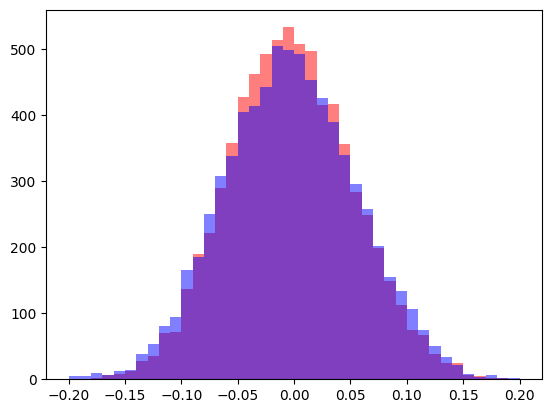

In [25]:
plt.hist(discreps_lv1, bins=np.linspace(-.2,.2,41), alpha=.5, color='red');
plt.hist(discreps_lv0, bins=np.linspace(-.2,.2,41), alpha=.5, color='blue');

Histogram above shows that we are closer to the Las Vegas model after adding in the lineup features

In [26]:
np.mean(np.abs(discreps_lv1)), np.mean(np.abs(discreps_lv0))

(0.04396098462270591, 0.04694740583228808)

Let's look at whether we get better predictions by making a weighted average of our model and the Las Vegas probs

In [27]:
weak_model_preds = d8['preds_test']
strong_model_preds = d1['preds_test']

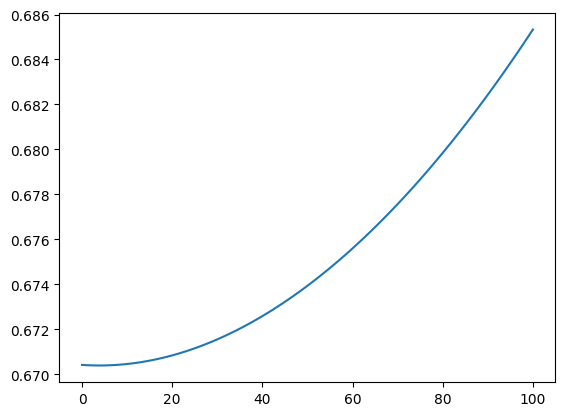

In [28]:
## Mixing in our first (very simple) model
ll_mix_vec_weak = [log_loss(y_test, (k*weak_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_weak)

In [29]:
ll_mix_vec_weak[0] - np.min(ll_mix_vec_weak), np.argmin(ll_mix_vec_weak)

(2.550669643641701e-05, 4)

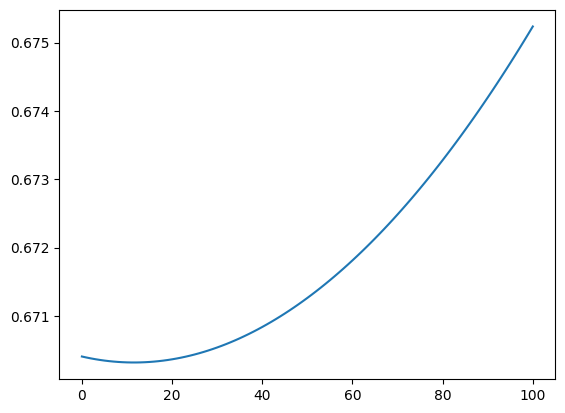

In [30]:
## Mixing in our latest model
ll_mix_vec_strong = [log_loss(y_test, (k*strong_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_strong)

In [31]:
ll_mix_vec_strong[0] - np.min(ll_mix_vec_strong), np.argmin(ll_mix_vec_strong)

(8.738639506111756e-05, 12)

In [32]:
pv_true = df_test.implied_prob_h_mid

In [33]:
# Simulate different model variations on a single test set
# Gives a sense of how much different models (each with the same quality)
# will vary
def ll_model_discrep_shuffle(probvec_true, discreps, num_trials, answers):
    # sim_outcome = np.random.binomial(n=1, p=probvec_true)
    llvec_mod = np.zeros(num_trials)
    discr1 = discreps.copy()
    for i in range(num_trials):
        np.random.shuffle(discr1)
        pv_mod = pv_true  + discr1
        llvec_mod[i] = log_loss(answers, pv_mod)
    return(llvec_mod)

In [34]:
losses = ll_model_discrep_shuffle(pv_true, discreps_lv1, 10000, y_test)

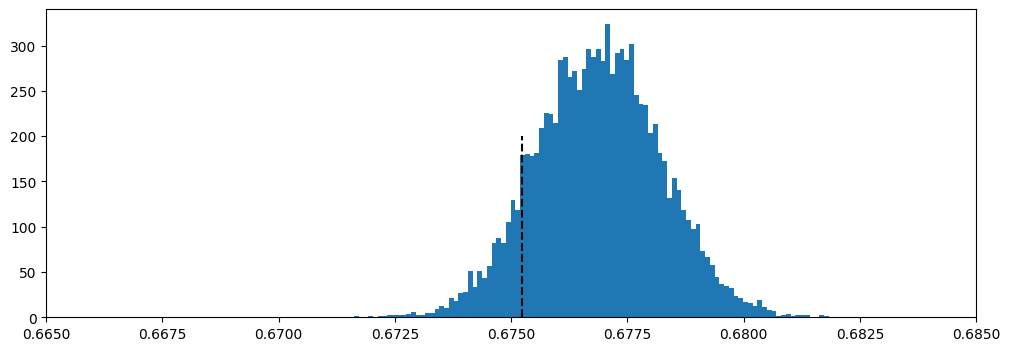

In [35]:
plt.figure(figsize=(12,4))
plt.hist(losses, bins=100);
plt.xlim([.665,.685]);
plt.vlines(x=log_loss(y_test, strong_model_preds), ymin=0, ymax=200, color='k', linestyle='--')

Conclusions

    - We went from ~40bps to ~30bps by adding lineup variables OBS, SLG (for home and away)

    - Changing variants, adding more variables did not seem to improve at all

    - Vegas model is still better overall, but evidence that our model captures effects that they don't

Next Steps

    - Want to model runs scored 
        
        -- will certainly be useful for predicting the over / under
        
        -- may also prove useful for predicting the winner of the game

    - Will want to use probabilistic regression to get a distribution on the runs scored rather than a point estimate